In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import scipy
import scipy.optimize
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import time
import statistics 
from extinction import ccm89, apply
from astropy import table
from astropy.io import ascii
from scipy.optimize import least_squares

# Object error

In [2]:
def error_spectra(spec_object): 

    flux = spec_object[:,1]
    lam  = spec_object[:,0]

#For how many points do we make the lines
    num = 10

    if len(flux)%num != 0:
        c = len(flux)%num
        flux = flux[:-c]
        lams = lam[:-c]
    
    else:
        lams = lam
        c = 0
    
    
    flux_new = flux.reshape((-1, num))
    lam_new  = lams.reshape((-1, num))
    m = []
    b = []
    sigma = []

    for n in range(len(lam_new)):
        r=[]
        error=[]
        
        a = np.polyfit(lam_new[n], flux_new[n], 1)
        m.append(a[0])
        b.append(a[1])
        y = m[n]*lam_new[n]+b[n]
          
        r = flux_new - y
        
        plt.plot(lam_new[n], flux_new[n], '.' )
        plt.plot(lam_new[n], y)
        plt.plot(lam_new[n], flux_new[n]-y, 'ko', markersize=1)
       
        plt.title('For n*10th Entry')
        plt.ylabel('Flux')
        plt.xlabel('Lamda')
    

    for i in r: 
        s = statistics.stdev(i)
        sigma.append(s)
    

# Here we make the error be the same size as the original lambda and then take the transpose

    error = list(np.repeat(sigma, num))
    l = [error[-1]] * c
    error = error + l

    error = np.asarray(error)
    
    return np.array([lam,error]).T

# Extinction Law

In [3]:
A_v = 1.0

def Alam(lamin, A_v):

    #Add extinction with R_v = 3.1 and A_v = 1 
    
    flux = np.ones(len(lamin))
    redreturn = apply(ccm89(lamin, 1.0, 3.1), flux)
    
    return redreturn

## Get templates

In [4]:
templates_gal = glob.glob('binnings/20A/gal/*')
templates_gal = [x for x in templates_gal if 'CVS' not in x and 'README' not in x]
templates_gal = np.array(templates_gal)


templates_sn = glob.glob('binnings/20A/sne/**/*')
templates_sn = [x for x in templates_sn if 'CVS' not in x and 'README' not in x]
templates_sn = np.array(templates_sn)


## Truncate

In [5]:
def select_templates(DATABASE, TYPES):

       
#    Selects templates of a given type(s) from a template database
    
#    Input: DATEBASE   list of templates
#           TYPES      which types should be selected
    
#    Output: array of templates of given type(s)
       
    database_trunc = list([])
    
    for type in TYPES:
        database_trunc += list([x for x in DATABASE if type in x])
    
    return np.array(database_trunc)

In [6]:

templates_sn_trunc = select_templates(templates_sn, ['/Ib/', '/II/'])


templates_gal_trunc = select_templates(templates_gal, ['/SB4'])



## Lambda and Resolution

In [7]:

resolution = 20 #Angstrom
upper      = 7000
lower      = 4000
interval   = (upper - lower)/resolution

#Making an arbitrary lambda, with upper, lower bounds and interval size

lam        =     np.linspace(lower, upper, interval)



/home/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


## Object we are interested in

In [8]:
# Object I'm interested in 

object_name = 'sn1987B.p07.dat'

object_spec =  np.loadtxt("/home/sam/Dropbox/superfit/binnings/20A/sne/II/sn1987B.p07.dat")

objecto = interpolate.interp1d(object_spec[:,0], object_spec[:,1],   bounds_error=False, fill_value='nan')

objecto = objecto(lam)



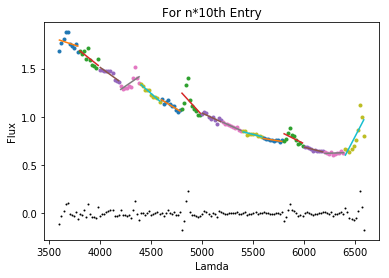

In [9]:
# Error 

error             =  error_spectra(object_spec)

object_err_interp =  interpolate.interp1d(error[:,0],  error[:,1],  bounds_error=False, fill_value='nan')
               
sigma             =  object_err_interp(lam)


# Core function of Superfit

In [10]:
def core(z,extcon):


    spec_gal = []
    spec_sn  = []
    
    
    #Obtain an array of interpolated gal
    
    for i in range(0, len(templates_gal_trunc)): 
        
        one_gal           =  np.loadtxt(templates_gal_trunc[i])
        
        gal_interp        =  interpolate.interp1d(one_gal[:,0]*(z+1),    one_gal[:,1],    bounds_error=False, fill_value='nan')
        
        spec_gal.append(gal_interp)
        
        
        
        
    #Obtain an array of interpolated sn  
        
    for i in range(0, len(templates_sn_trunc)): 
        
        one_sn           =  np.loadtxt(templates_sn_trunc[i])
        
        sn_interp        =  interpolate.interp1d(one_sn[:,0]*(z+1),    one_sn[:,1]*10**(extcon * Alam(one_sn[:,0],1 )),    bounds_error=False, fill_value='nan')
        
        spec_sn.append(sn_interp)
      


    # Obtain sn and gal and add a new axis
    
    gal = []
    sn  = []
    
    
    #For each spectrum in the galaxy library
    for i in spec_gal: 
        
        gal.append(i(lam))
    
    
    #For each spectrum in the supernova library 
    for i in spec_sn:    
    
        sn.append(i(lam))
    
    
        
    
    gal = np.array(gal)
    sn  = np.array(sn)
    
    
    
    # Redefine sn and gal by adding a new axis
    
    gal = gal[:, np.newaxis,:]
    sn  = sn[np.newaxis,:,:]


    
    # Apply linear algebra witchcraft
    
    c = 1 / ( np.nansum(sn**2,2) * np.nansum(gal**2,2) - np.nansum(gal*sn,2)**2 )
 
    
#Obtain coefficients of proportionality for Supernova and Host Galaxies templates
    
    b = c * (np.nansum(gal**2,2)*np.nansum(sn*objecto,2) - np.nansum(gal*sn,2)*np.nansum(gal*objecto,2))
    
    d = c * (np.nansum(sn**2,2)*np.nansum(gal*objecto,2) - np.nansum(gal*sn,2)*np.nansum(sn*objecto,2))
    

# Rewrite b and d with better names and with a new axis introduced, for the common lambda 
    
    supernova = b[:, :, np.newaxis]
    
    galaxy = d[:, :, np.newaxis]

    
# Figure out number of degrees of freedom 
    
    a = (  (objecto - (supernova * sn) + galaxy * gal)/(sigma) )**2
    
    a = np.isnan(a)
    
    times = np.nansum(a,2)
    
    #How many times?
    times = len(lam) - times 
    
    
# NOW obtain chi2

    chi2  =  np.nansum(  ((objecto - (supernova * sn + galaxy * gal))/(sigma) )**2  ,2) 

# Reduced chi2

    reduchi2 = chi2/(times-2)
    
# Flatten the matrix out and obtain from those indices the corresponding values of b and d 
    
    reduchi2_1d = reduchi2.ravel()
    
    index = np.argsort(reduchi2_1d)
    
    idx = np.unravel_index(index[0], reduchi2.shape)
    
    
# Find the values of the proportionality constants 

    bb = b[idx[0]][idx[1]]
    dd = d[idx[0]][idx[1]]
    
    
    
    supernova_file  = templates_sn_trunc[idx[1]]
    host_galaxy_file = templates_gal_trunc[idx[0]]
    
    
    
    nova   = np.loadtxt('/home/sam/Dropbox/superfit/' + supernova_file)
    host   = np.loadtxt('/home/sam/Dropbox/superfit/' + host_galaxy_file)
    
    
    
    #Interpolate supernova and host galaxy 
    
    nova_int = interpolate.interp1d(nova[:,0], nova[:,1],   bounds_error=False, fill_value='nan')

    host_int = interpolate.interp1d(host[:,0], host[:,1],   bounds_error=False, fill_value='nan')


    # Combination of the data  

    host_nova = bb*nova_int(lam) + dd*host_int(lam)
    
    """
    output = table.Table(np.array([object_name, host_galaxy_file, supernova_file, bb , dd, z, chi2[idx], extcon ]), 
                     
                     names  =  ('OBJECT', 'GALAXY', 'SN', 'CONST_SN','CONST_GAL','Z','CHI2','CONST_Alam'), 
                     
                     dtype  =  ('S100', 'S100', 'S100','f','f','f','f','f'))
        
    
     """
   
    plt.plot(lam/(z+1), objecto,'r')
    plt.plot(lam, host_nova,'g')


    plt.ylabel('Flux arbitrary')
    plt.xlabel('Lamda')
    plt.title('Templates')
    plt.show()   
            
    
        
    # Here instead of printing out a table a print out the specific value for chi2
    
    output = chi2[idx]
        
    
    return output


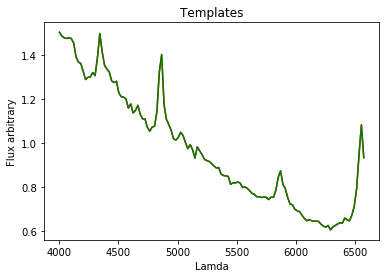

0.0

In [11]:
core(0,0)

# Define z and Alam constant

In [12]:
#number = 11
#
#
#z      =    np.linspace(0,0.1,number)
#
#extcon =    np.linspace(-2,2,number)

In [13]:
#x = np.concatenate((z, extcon), axis = None

In [14]:
start = time.time()

In [15]:
#results = []

In [16]:
# Using a loop we can obtain all possible values for chi2 without the need for a minimizer 
#(as an alternative technique)

#for j in z:
#    for i in extcon:
#        
#        
#        a = core(j,i)
#        
#        results.append(a)
#
#        result = table.vstack(results)
#        
#        result.sort('CHI2')


In [17]:
#table.Table.show_in_notebook(result)

In [18]:
# Example to see if the wrapper works appropriately 

z_extcon = np.array([0,0])

In [19]:
def wrap(z_extcon):
    
    z = z_extcon[0]
     
    extcon = z_extcon[1]
    
    ans = core(z,extcon)
    
    
    return ans

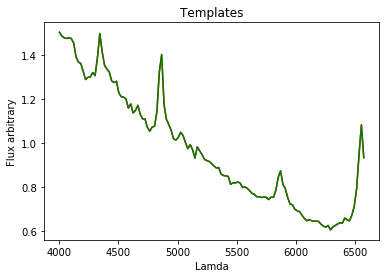

0.0

In [20]:
wrap(z_extcon)

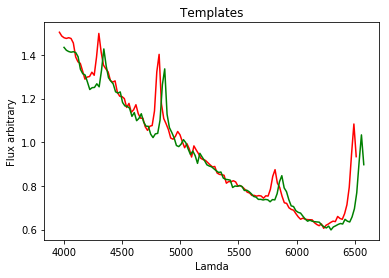

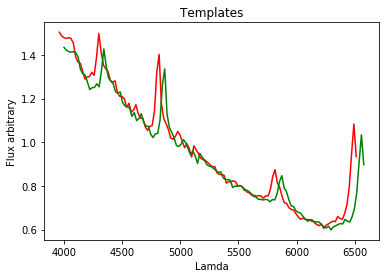

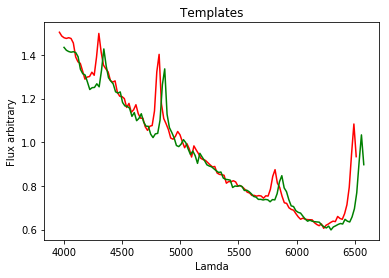

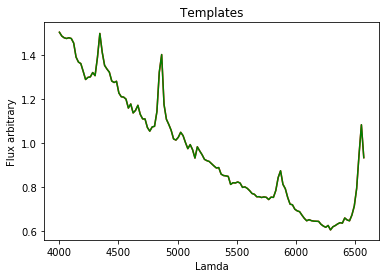

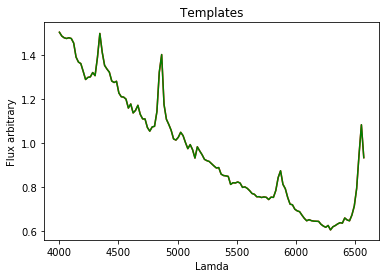

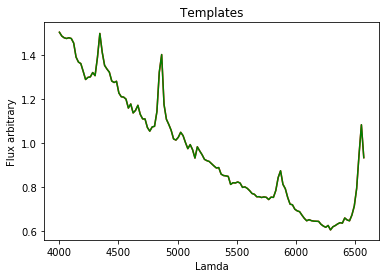

In [21]:
# Minimization 

init_guess = np.array([0.01, 0])

answer = least_squares(wrap, init_guess, method = 'trf')



In [22]:
answer

 active_mask: array([0., 0.])
        cost: 2.409654487940907e-15
         fun: array([6.9421243e-08])
        grad: array([6.75997619e-09, 4.06086486e-10])
         jac: array([[0.09737619, 0.0058496 ]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 2
        njev: 2
  optimality: 6.759976187188901e-09
      status: 1
     success: True
           x: array([2.74006232e-08, 2.34096500e-05])

In [23]:
z_and_extcon = answer['x']

In [24]:
zfinal = z_and_extcon[0]

In [25]:
extcon_final = z_and_extcon[1]

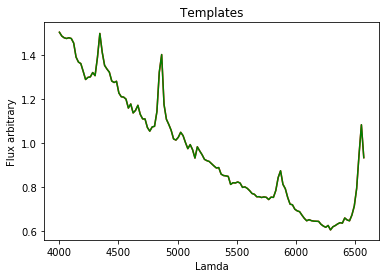

6.94212429727516e-08

In [26]:
core(zfinal, extcon_final)

In [27]:
end = time.time()
print(end - start, 'seconds')

2.3053009510040283 seconds
